<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

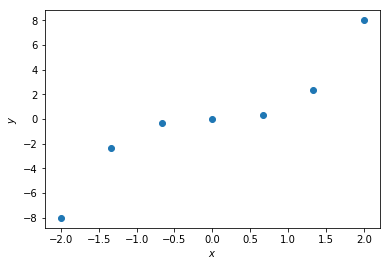

In [3]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

-2.53765262771e-16


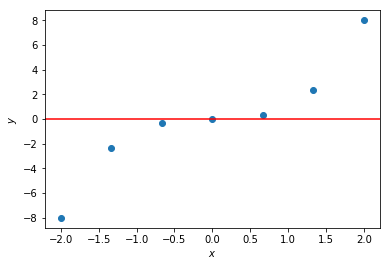

In [9]:
# Ваш код здесь
print (y.mean())
plt.scatter(X, y)
plt.axhline(y.mean(), color='r', linestyle='-')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.show()

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

-3.55555555556 2.66666666667


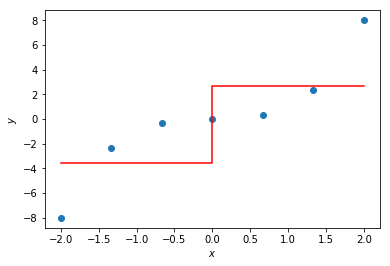

In [44]:
# Ваш код здесь
x1 = [x for x in X if x < 0]
x2 = [x for x in X if x >= 0]
y1 = [yi for i, yi in enumerate(y) if X[i] < 0]
y2 = [yi for i, yi in enumerate(y) if X[i] >= 0]

print (np.mean(y1), np.mean(y2))

y_plot = []
for x in X:
    if (x < 0):
        y_plot.append(np.mean(y1))
    else : y_plot.append(np.mean(y2))

plt.scatter(X, y)
plt.step(X, y_plot,'r', where='post')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.show()

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [48]:
def var(X, y):
    return 1/len(X) * sum([(yj - (1/len(X)) * sum([yi for yi in y]))**2 for yj in y] )
def regression_var_criterion(X, y, t):
    Xl = [x for x in X if x < t]
    Xr = [x for x in X if x >= t]
    yl = [yi for i, yi in enumerate(y) if X[i] < t]
    yr = [yi for i, yi in enumerate(y) if X[i] >= t]
    return (var(X, y) - (len(Xl)/len(X)) * var(Xl, yl) - (len(Xr)/len(X)) * var(Xr, yr))

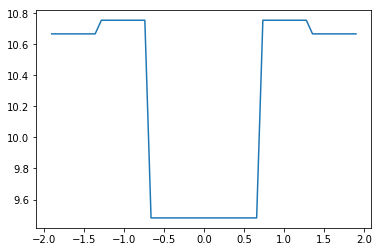

In [52]:
# Ваш код здесь
t = np.linspace(-1.9, 1.9)
q_plot = [regression_var_criterion(X, y, ti) for ti in t]
plt.plot(t, q_plot)

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

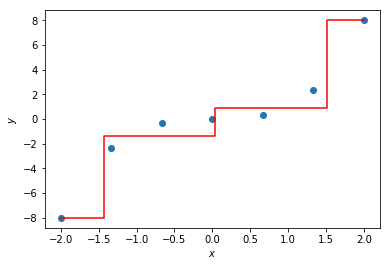

In [61]:
# Ваш код здесь
x11 = [xi for xi in x1 if xi < -1.5]
x12 = [xi for xi in x1 if xi >= -1.5]
x21 = [xi for xi in x2 if xi < 1.5]
x22 = [xi for xi in x2 if xi >= 1.5]

y11 = [yi for i, yi in enumerate(y1) if x1[i] < -1.5]
y12 = [yi for i, yi in enumerate(y1) if x1[i] >= -1.5]
y21 = [yi for i, yi in enumerate(y2) if x2[i] < 1.5]
y22 = [yi for i, yi in enumerate(y2) if x2[i] >= 1.5]

x_plot = np.linspace(-2, 2)
y_plot = []
for x in x_plot:
    if (x < -1.5):
        y_plot.append(np.mean(y11))
    elif (x >= -1.5 and x < 0):
        y_plot.append(np.mean(y12))
    elif (x >= 0 and x < 1.5):
        y_plot.append(np.mean(y21))
    elif (x >= 1.5):
        y_plot.append(np.mean(y22))
    else: 
        pass

plt.scatter(X, y)
plt.step(x_plot, y_plot,'r', where='post')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.show()

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [67]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [68]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [69]:
# Ваш код здесь
from math import floor
df['age'] = df['age'] / 365.25
df['age'] = df['age'].apply(floor)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [78]:
df_chl = pd.get_dummies(data=df['cholesterol'])
df_gl = pd.get_dummies(data=df['gluc'])
arr = [df, df_chl, df_gl]
df = pd.concat(arr, axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,1,2,3,1,2,3
id,,,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,1,0,0
2,51,1,165,64.0,130,70,3,1,0,0,0,1,0,0,1,1,0,0
3,48,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,1,0,0


In [82]:
df.drop(['cholesterol', 'gluc'], axis=1, inplace=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,1,2,3,1,2,3
id,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,51,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,48,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [83]:
X = df.drop(['cardio'], axis=1, inplace=False)
y = df['cardio']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=17, test_size=0.3)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

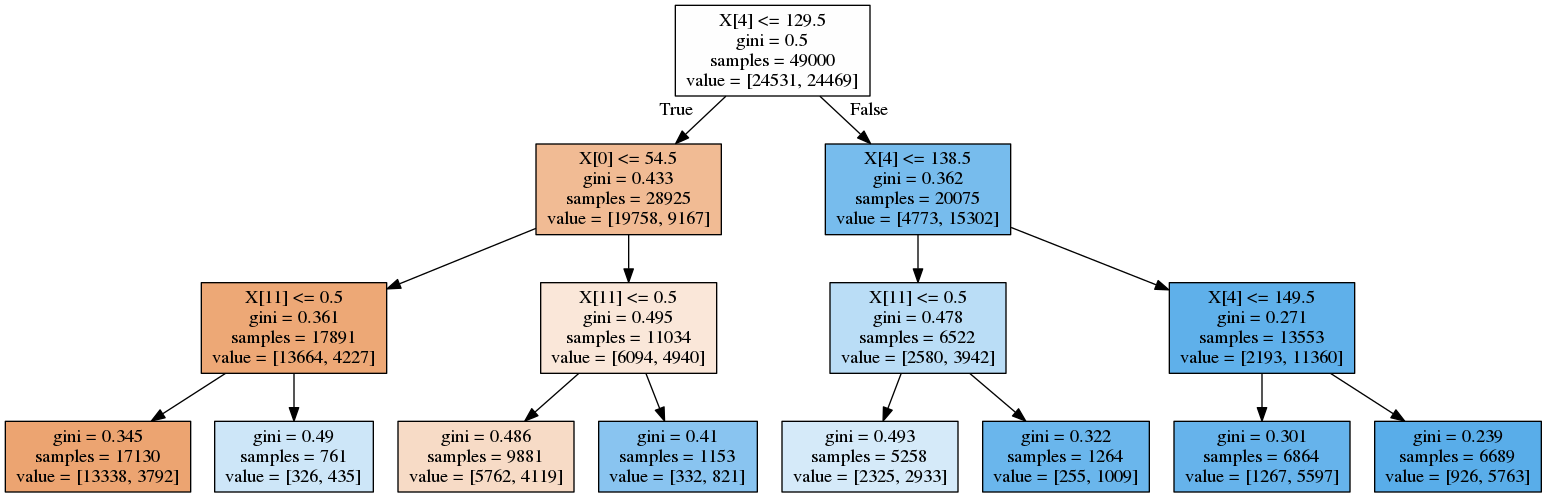

In [118]:
# Ваш код здесь
tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_classifier.fit(X_train, y_train)
export_graphviz(tree_classifier, out_file='tree.dot', filled=True)

!dot -Tpng tree.dot -o tree.png

from IPython.display import Image
Image("tree.png")

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

In [105]:
X.columns[[4,0, 11]]

Index(['ap_hi', 'age', 3], dtype='object')

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [119]:
# Ваш код здесь
y_pred = tree_classifier.predict(X_valid)
acc1 = accuracy_score(y_valid, y_pred)

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [112]:
from sklearn.metrics import make_scorer
tree_classifier = DecisionTreeClassifier(random_state=17)
tree_params = {'max_depth': list(range(2, 11))}
scorer = make_scorer(accuracy_score)

tree_grid = GridSearchCV(tree_classifier, tree_params, cv=5, n_jobs=-1, scoring=scorer)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

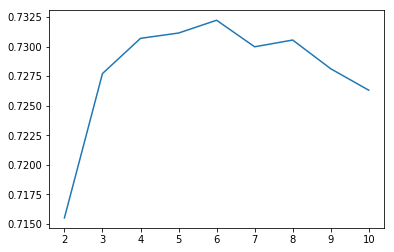

In [115]:
# Ваш код здесь
tree_grid.cv_results_['mean_test_score']
plt.plot(list(range(2, 11)), tree_grid.cv_results_['mean_test_score'])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [116]:
# Ваш код здесь
tree_grid.best_params_

{'max_depth': 6}

In [122]:
acc2 = tree_grid.best_score_
(acc2 - acc1)/acc1 * 100

1.5165662224485721

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [151]:
# Ваш код здесь
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')


In [152]:
df.drop(['height', 'weight', 'ap_lo', 'gluc', 'alco', 'active'], inplace = True, axis=1)
df['age'] = df['age'] / 365.25
df['age'] = df['age'].apply(floor)
df.head()

,age,gender,ap_hi,cholesterol,smoke,cardio
id,,,,,,
0,50,2,110,1,0,0
1,55,1,140,3,0,1
2,51,1,130,3,0,1
3,48,2,150,1,0,1
4,47,1,100,1,0,0


In [153]:
df_chl = pd.get_dummies(data=df['cholesterol'], prefix='chl')
df_chl.head()

mdict = {}
for age in df['age'].value_counts().index.tolist():
    if ((age >= 45) & (age < 50)):
        mdict[age] = 0
    elif ((age >= 50) & (age < 55)):
        mdict[age] = 1
    elif ((age >= 55) & (age < 60)):
        mdict[age] = 2
    elif ((age >= 60) & (age < 65)):
        mdict[age] = 3
    else : mdict[age] = np.nan

df['age'] = df['age'].map(mdict)
df_age = pd.get_dummies(data=df['age'], prefix='age')


In [154]:
mdict = {}
for ap_hi in df['ap_hi'].value_counts().index.tolist():
    if ((ap_hi >= 120) & (ap_hi < 140)):
        mdict[ap_hi] = 0
    elif ((ap_hi >= 140) & (ap_hi < 160)):
        mdict[ap_hi] = 1
    elif ((ap_hi >= 160) & (ap_hi < 180)):
        mdict[ap_hi] = 2
    else : mdict[ap_hi] = np.nan


df['ap_hi'] = df['ap_hi'].map(mdict)
df_ap = pd.get_dummies(data=df['ap_hi'], prefix='ap_hi')

In [155]:
df = pd.concat([df, df_chl, df_age, df_ap], axis=1)
df.head()

,age,gender,ap_hi,cholesterol,smoke,cardio,chl_1,chl_2,chl_3,age_0.0,age_1.0,age_2.0,age_3.0,ap_hi_0.0,ap_hi_1.0,ap_hi_2.0
id,,,,,,,,,,,,,,,,
0,1.0,2,NaN,1,0,0,1,0,0,0,1,0,0,0,0,0
1,2.0,1,1.0,3,0,1,0,0,1,0,0,1,0,0,1,0
2,1.0,1,0.0,3,0,1,0,0,1,0,1,0,0,1,0,0
3,0.0,2,1.0,1,0,1,1,0,0,1,0,0,0,0,1,0
4,0.0,1,NaN,1,0,0,1,0,0,1,0,0,0,0,0,0


In [157]:
df.drop(['age', 'ap_hi', 'cholesterol'], axis=1, inplace=True)
df['gender'] = df['gender'] - 1
df.head()

,gender,smoke,cardio,chl_1,chl_2,chl_3,age_0.0,age_1.0,age_2.0,age_3.0,ap_hi_0.0,ap_hi_1.0,ap_hi_2.0
id,,,,,,,,,,,,,
0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,1,0,0,1,0,0,1,0
2,0,0,1,0,0,1,0,1,0,0,1,0,0
3,1,0,1,1,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0


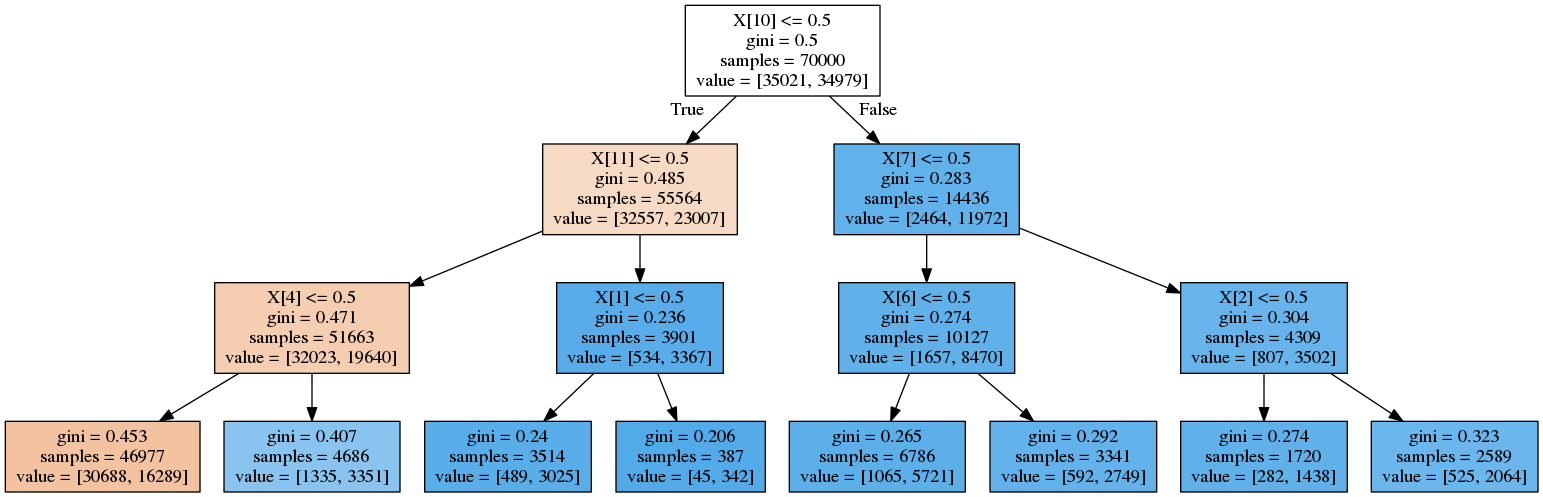

In [161]:
X = df.drop(['cardio'], axis=1)
y = df['cardio']

tree_cat_classifier = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_cat_classifier.fit(X, y)

export_graphviz(tree_cat_classifier, out_file='cat_tree.dot', filled=True)

!dot -Tpng cat_tree.dot -o cat_tree.png

from IPython.display import Image
Image("cat_tree.png")

In [162]:
X.columns[10]

'ap_hi_1.0'